In [8]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import pdb
from scipy.spatial import ConvexHull
import k3d
from mpl_toolkits import mplot3d
from itertools import chain
import ipympl #Required for interactive control
from scipy.spatial import Delaunay, delaunay_plot_2d, Voronoi, voronoi_plot_2d
import math
import warnings
# warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

In [2]:
def read_binary_stl(filename):
    with open(filename, "rb") as f:
        # 80バイトのヘッダーをスキップ
        header = f.read(80)
        print("Header:", header.decode(errors="ignore"))

        # 4バイトの三角形数を取得
        num_triangles = struct.unpack("<I", f.read(4))[0]
        print("Number of triangles:", num_triangles)

        triangles = []

        for _ in range(num_triangles):
            # 1つの三角形のデータ（50バイト）
            data = f.read(50)

            # 法線ベクトル (3 x float32)
            normal = struct.unpack("<fff", data[0:12])
            # 3つの頂点座標 (3 x (3 x float32))
            v1 = struct.unpack("<fff", data[12:24])
            v2 = struct.unpack("<fff", data[24:36])
            v3 = struct.unpack("<fff", data[36:48])

            # 2バイトの属性バイト数（無視する）
            attr_byte_count = struct.unpack("<H", data[48:50])[0]

            # triangles.append((normal, v1, v2, v3))
            triangles.append((v1, v2, v3))

        return triangles


In [3]:
# Read STL
# stl_file = "box.stl"
stl_file = "pyramid.stl"
# stl_file = "octo.stl"
# stl_file = "bridge_wall.stl"
triangles = read_binary_stl(stl_file)

# Store Z data
zs = np.array([])
if triangles:
    for t in triangles:
        for tri in t:
            zs = np.append(zs, tri[2])



Header: STLB ATF 13.20.0.188 COLOR=                                                 
Number of triangles: 774


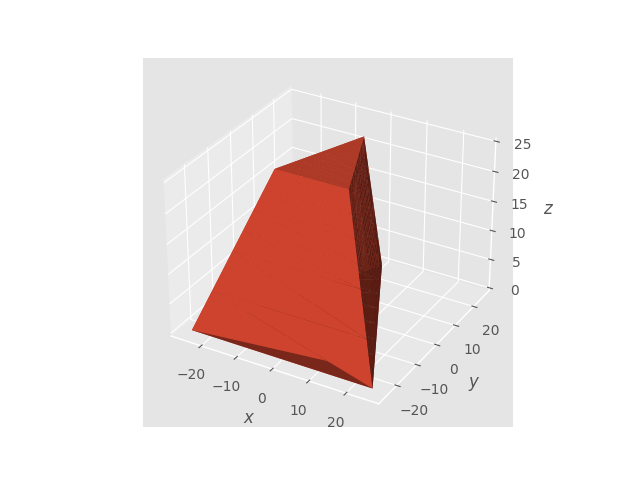

In [4]:
tri_points = list(chain.from_iterable(triangles))
x, y, z = zip(*tri_points)
tri_idx = [(3 * i, 3 * i + 1, 3 * i + 2) for i in range(len(triangles))]
ax = plt.figure().add_subplot(projection='3d')
ax.plot_trisurf(x, y, z, triangles=tri_idx)
ax.set_xlabel(r"$x$"); ax.set_ylabel(r"$y$"); ax.set_zlabel(r"$z$")
plt.show()

In [5]:
# Z points for slicing 
number_of_slicing_planes = 10 
z_points = np.linspace(zs.min(),zs.max(),number_of_slicing_planes) 
z_points

array([ 0.        ,  2.77777778,  5.55555556,  8.33333333, 11.11111111,
       13.88888889, 16.66666667, 19.44444444, 22.22222222, 25.        ])

In [21]:
xy_dict = {}
for zp in z_points:
    # points = np.array([])
    points = []
    print('zp:',zp)
    for t in triangles:
        # print('triangle index:',triangles.index(t))
        local_points = np.array([])
        first = t[0]
        second = t[1]
        third = t[2]
        x1 = first[0]
        y1 = first[1]
        x2 = second[0]
        x3 = third[0]
        y2 = second[1]
        y3 = third[1]
        z1 = first[2]
        z2 = second[2]
        z3 = third[2]
        if zp >= z1 and zp <= z2:
            k = (zp-z1)/(z2-zp)
            x = 1/(1+k)*x1 + k/(1+k)*x2
            y = 1/(1+k)*y1 + k/(1+k)*y2
            if not math.isnan(x) and not math.isnan(y):
                if not any(np.array_equal(np.array([x,y]), p) for p in points):
                    points.append(np.array([x,y]))
                    # if points.size == 0:
                    #     points = np.append(points,np.array([x,y]))
                    # else:
                    #     points = np.vstack([points,np.array([x,y])])
                # if np.array([x,y]) not in local_points:
                    if local_points.size == 0:
                        local_points = np.append(local_points,np.array([x,y]))
                    else:
                        local_points = np.vstack([local_points,np.array([x,y])])
        if zp >= z2 and zp <= z3:
            k = (zp-z2)/(z3-zp)
            x = 1/(1+k)*x2 + k/(1+k)*x3
            y = 1/(1+k)*y2 + k/(1+k)*y3
            if not math.isnan(x) and not math.isnan(y):
                if not any(np.array_equal(np.array([x,y]), p) for p in points):
                    points.append(np.array([x,y]))
                    # if points.size == 0:
                    #     points = np.append(points,np.array([x,y]))
                    # else:
                    #     points = np.vstack([points,np.array([x,y])])
                # if np.array([x,y]) not in local_points:
                    if local_points.size == 0:
                        local_points = np.append(local_points,np.array([x,y]))
                    else:
                        local_points = np.vstack([local_points,np.array([x,y])])
        if zp >= z3 and zp <= z1:
            k = (zp-z3)/(z1-zp)
            x = 1/(1+k)*x3 + k/(1+k)*x1
            y = 1/(1+k)*y3 + k/(1+k)*y1
            if not math.isnan(x) and not math.isnan(y):
                if not any(np.array_equal(np.array([x,y]), p) for p in points):
                    points.append(np.array([x,y]))
                # if np.array([x,y]) not in points:
                #     if len(points.size == 0:
                #         points = np.append(points,np.array([x,y]))
                #     else:
                #         points = np.vstack([points,np.array([x,y])])
                # if np.array([x,y]) not in local_points:
                    if local_points.size == 0:
                        local_points = np.append(local_points,np.array([x,y]))
                    else:
                        local_points = np.vstack([local_points,np.array([x,y])])
        if zp >= z2 and zp <= z1:
            k = (zp-z2)/(z1-zp)
            x = 1/(1+k)*x2 + k/(1+k)*x1
            y = 1/(1+k)*y2 + k/(1+k)*y1
            if not math.isnan(x) and not math.isnan(y):
                if not any(np.array_equal(np.array([x,y]), p) for p in points):
                    points.append(np.array([x,y]))
                    # if points.size == 0:
                    #     points = np.append(points,np.array([x,y]))
                    # else:
                    #     points = np.vstack([points,np.array([x,y])])
                # if np.array([x,y]) not in local_points:
                    if local_points.size == 0:
                        local_points = np.append(local_points,np.array([x,y]))
                    else:
                        local_points = np.vstack([local_points,np.array([x,y])])
        if zp >= z3 and zp <= z2:
            k = (zp-z3)/(z2-zp)
            x = 1/(1+k)*x3 + k/(1+k)*x2
            y = 1/(1+k)*y3 + k/(1+k)*y2
            if not math.isnan(x) and not math.isnan(y):
                if not any(np.array_equal(np.array([x,y]), p) for p in points):
                    points.append(np.array([x,y]))
                    # if len(points) == 0:
                        # points = np.append(points,np.array([x,y]))
                        # points.append(
                    # else:
                        # points = np.vstack([points,np.array([x,y])])
                # if np.array([x,y]) not in local_points:
                    if local_points.size == 0:
                        local_points = np.append(local_points,np.array([x,y]))
                    else:
                        local_points = np.vstack([local_points,np.array([x,y])])
        if zp >= z1 and zp <= z3:
            k = (zp-z1)/(z3-zp)
            x = 1/(1+k)*x1 + k/(1+k)*x3
            y = 1/(1+k)*y1 + k/(1+k)*y3
            if not math.isnan(x) and not math.isnan(y):
                if not any(np.array_equal(np.array([x,y]), p) for p in points):
                    points.append(np.array([x,y]))
                    # if points.size == 0:
                    #     points = np.append(points,np.array([x,y]))
                    # else:
                    #     points = np.vstack([points,np.array([x,y])])
                # if np.array([x,y]) not in local_points:
                    if local_points.size == 0:
                        local_points = np.append(local_points,np.array([x,y]))
                    else:
                        local_points = np.vstack([local_points,np.array([x,y])])
    xy_dict[zp] = points

zp: 0.0
zp: 2.7777777777777777
zp: 5.555555555555555
zp: 8.333333333333332
zp: 11.11111111111111
zp: 13.88888888888889
zp: 16.666666666666664
zp: 19.444444444444443
zp: 22.22222222222222
zp: 25.0
[array([-3.125, 18.75 ]), array([-8.8817842e-15,  2.5000000e+01]), array([-6.25, 12.5 ]), array([-9.375,  6.25 ]), array([-12.5,   0. ]), array([-15.625,  -6.25 ]), array([-18.75, -12.5 ]), array([-21.875, -18.75 ]), array([-25., -25.]), array([ 25., -25.]), array([ 21.875, -18.75 ]), array([12.5,  0. ]), array([9.375, 6.25 ]), array([ 18.75, -12.5 ]), array([15.625, -6.25 ]), array([ 6.25, 12.5 ]), array([ 3.125, 18.75 ])]


/var/folders/z1/r5wl186d23314ypyzy3t8wj80000gn/T/ipykernel_96587/1053053041.py:22: RuntimeWarning: invalid value encountered in scalar divide
  k = (zp-z1)/(z2-zp)
/var/folders/z1/r5wl186d23314ypyzy3t8wj80000gn/T/ipykernel_96587/1053053041.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  k = (zp-z2)/(z3-zp)


KeyError: 0.0

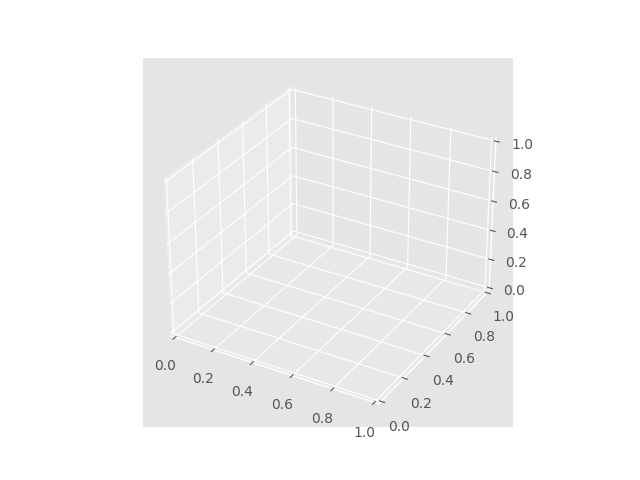

In [58]:
ax = plt.figure().add_subplot(projection='3d')
for zp in z_points:
    xy_points = xy_dict[zp]
    print('zp:',zp)
    for xy_point in xy_points:
        # print(len(xy_point))
        plt.plot(xy_points[:,0], xy_points[:,1], zp)
plt.show()

zp: 8.5


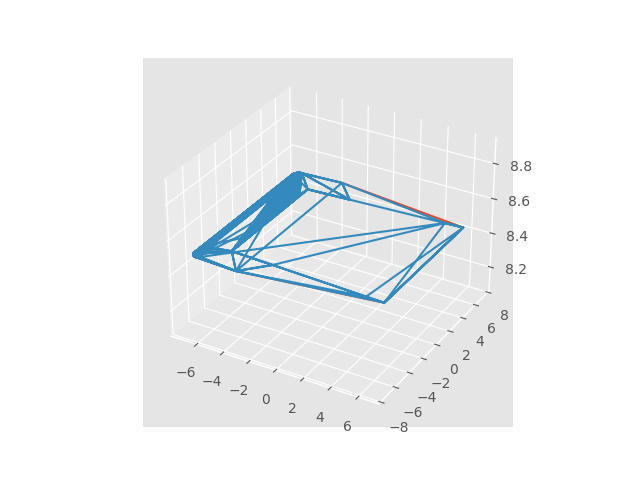

zp: 22.4950008392334


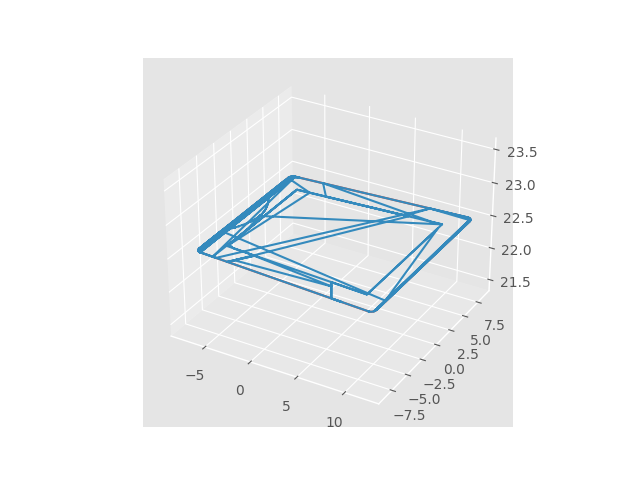

zp: 36.4900016784668


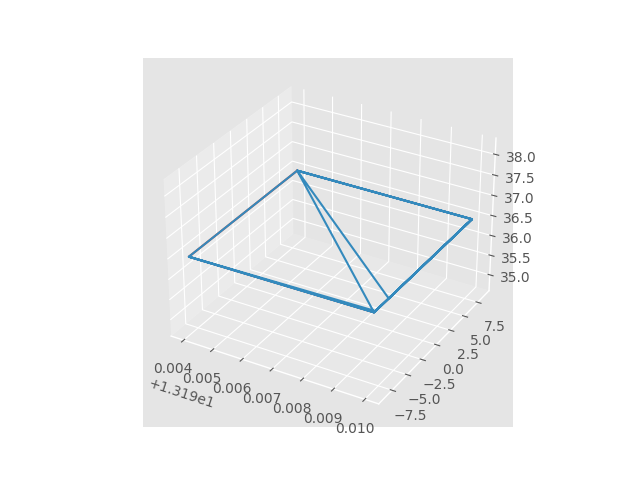

In [24]:
for zp in z_points:
    ax = plt.figure().add_subplot(projection='3d')
    xy_points = xy_dict[zp]
    print('zp:',zp)
    try:
        hull = ConvexHull(xy_points)
        points = hull.points
        hull_points = points[hull.vertices]
        hp = np.vstack((hull_points, hull_points[0]))
        plt.plot(hp[:,0], hp[:,1], zp)
        plt.plot(xy_points[:,0], xy_points[:,1], zp)
        # tri = Delaunay(xy_points)
        # delaunay_plot_2d(tri)
        
        # plt.scatter(points[:,0], points[:,1], zp)
    except Exception:
        pass
    plt.show()